# Task 2 (5 Points): Sentiment Analysis (Part 3)

#### We will use ‘The 20 Newsgroups dataset’. The code to download data using sk-learn is provided in attached notebook (task2_data.ipynb). Report the accuracy on test data set for following models: 

# Part 1
## Without any pre-trained embeddings

## Loading Dataset

We will use The 20 Newsgroups dataset 
Dataset [homepage](http://qwone.com/~jason/20Newsgroups/): 

Scikit-learn includes some nice helper functions for retrieving the 20 Newsgroups dataset-- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html. We'll use them below to retrieve the dataset.

Also look at results fron non- neural net models here : https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html#sphx-glr-auto-examples-text-plot-document-classification-20newsgroups-py



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
from sklearn.datasets import fetch_20newsgroups

train = fetch_20newsgroups(subset='train',
                           remove=('headers', 'footers', 'quotes'))

test = fetch_20newsgroups(subset='test',
                           remove=('headers', 'footers', 'quotes'))

In [3]:
from pathlib import Path
folder=Path('/content/gdrive/My Drive/ColabNotebooks')

In [4]:
print(train.data[0])

I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.


In [5]:
print(train.target[0])

7


In [6]:
train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [7]:
len(train.target_names)

20

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


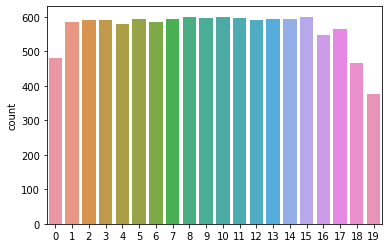

In [8]:
import seaborn as sns

# Plot the number of tokens of each length.
sns.countplot(train.target);

In [9]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from datetime import datetime
from pathlib import Path
import pandas as pd

import torchtext.data as ttd

In [10]:
df_train = pd.DataFrame({'data':train.data, 'labels':train.target})
df_test = pd.DataFrame({'data':test.data, 'labels':test.target})

In [11]:
df_train.isna().sum(axis=0)

data      0
labels    0
dtype: int64

In [12]:
df_train.head()

,data,labels
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [13]:
df_test.head()

,data,labels
0,I am a little confused on all of the models of...,7
1,I'm not familiar at all with the format of the...,5
2,"\nIn a word, yes.\n",0
3,\nThey were attacking the Iraqis to drive them...,17
4,\nI've just spent two solid months arguing tha...,19


In [14]:
df_train['labels'].value_counts(), df_test['labels'].value_counts()

(10    600
 15    599
 8     598
 9     597
 11    595
 13    594
 7     594
 14    593
 5     593
 12    591
 2     591
 3     590
 6     585
 1     584
 4     578
 17    564
 16    546
 0     480
 18    465
 19    377
 Name: labels, dtype: int64, 10    399
 8     398
 15    398
 9     397
 11    396
 7     396
 13    396
 5     395
 14    394
 2     394
 12    393
 3     392
 6     390
 1     389
 4     385
 17    376
 16    364
 0     319
 18    310
 19    251
 Name: labels, dtype: int64)

In [15]:
df_train=df_train.sample(frac=1)

In [16]:
df_train.head()

,data,labels
3964,\n The relevance is that if you've got x...,16
2258,I own a Mac IIsi and am considering upgrades (...,4
1344,\nThis is definitely the wrong newsgroup for t...,12
2328,": I\n: |> Jim,\n: |> \n: |> I always thought t...",0
8011,,7


In [17]:
df_train.to_csv(folder / 'newsgroup20_train.csv', index=False)
df_test.to_csv(folder / 'newsgroup20_test.csv', index=False)

In [18]:
import sys
import csv
csv.field_size_limit(sys.maxsize)

131072

In [19]:
TEXT = ttd.Field(
    sequential=True,
    batch_first=True,
    lower=False,
    tokenize='spacy',
    pad_first=True)

LABEL = ttd.LabelField()
#LABEL = ttd.Field(sequential=False, use_vocab=False, is_target=True)

dataset = ttd.TabularDataset(
    path= folder / 'newsgroup20_train.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

test_dataset = ttd.TabularDataset(
    path= folder / 'newsgroup20_test.csv',
    format='csv',
    skip_header=True,
    fields=[('data', TEXT), ('label', LABEL)]
)

In [20]:
print(dataset.examples[0].data)

['\n       ', 'The', 'relevance', 'is', 'that', 'if', 'you', "'ve", 'got', 'x', 'homicides', 'and', 'reduce', '\n', 'the', 'number', 'of', 'gun', 'homicides', 'in', 'that', 'group', ',', 'but', 'x', 'does', "n't", 'decrease', '\n', 'by', 'a', 'significant', 'amount', ',', 'have', 'you', 'made', 'an', 'improvement', ',', 'and', 'is', 'that', '\n', 'improvement', 'worth', 'what', 'you', "'ve", 'paid', '?', '\n\n\n       ', 'If', 'a', 'baseball', 'bat', 'is', 'a', 'tenth', 'as', 'likely', 'to', 'kill', 'a', 'victim', 'as', 'a', 'gun', ',', '\n', 'is', 'that', 'any', 'comfort', 'to', 'that', 'tenth', '?', '\n\n\n       ', 'I', "'ve", 'faced', 'a', 'knife', '.', ' ', 'And', 'I', 'was', 'damn', 'annoyed', 'I', 'did', "n't", '*', 'have', '*', '\n', 'a', 'gun', '.', ' ', 'All', 'the', 'statistics', 'in', 'the', 'world', 'did', "n't", 'change', 'the', 'fact', 'that', '\n', '*', 'he', '*', 'was', 'interested', 'in', 'cutting', '*', 'me', '*', '.', '\n\n\n       ', '"', 'Anyone', 'trained', 'in',

In [21]:
print(test_dataset.examples[0].data)

['I', 'am', 'a', 'little', 'confused', 'on', 'all', 'of', 'the', 'models', 'of', 'the', '88', '-', '89', 'bonnevilles', '.', '\n', 'I', 'have', 'heard', 'of', 'the', 'LE', 'SE', 'LSE', 'SSE', 'SSEI', '.', 'Could', 'someone', 'tell', 'me', 'the', '\n', 'differences', 'are', 'far', 'as', 'features', 'or', 'performance', '.', 'I', 'am', 'also', 'curious', 'to', '\n', 'know', 'what', 'the', 'book', 'value', 'is', 'for', 'prefereably', 'the', '89', 'model', '.', 'And', 'how', 'much', '\n', 'less', 'than', 'book', 'value', 'can', 'you', 'usually', 'get', 'them', 'for', '.', 'In', 'other', 'words', 'how', '\n', 'much', 'are', 'they', 'in', 'demand', 'this', 'time', 'of', 'year', '.', 'I', 'have', 'heard', 'that', 'the', 'mid', '-', 'spring', '\n', 'early', 'summer', 'is', 'the', 'best', 'time', 'to', 'buy', '.']


In [22]:
import random
SEED=10
train_dataset, valid_dataset = dataset.split(split_ratio=0.7,random_state = random.seed(SEED)) # default is 0.7

In [23]:
print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of validation examples: {len(valid_dataset)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 7920
Number of validation examples: 3394
Number of testing examples: 7532


In [24]:
TEXT.build_vocab(train_dataset)
LABEL.build_vocab(train_dataset)

In [25]:
vocab_text = TEXT.vocab

In [28]:
vocab_label = LABEL.vocab

In [31]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)

cuda:0


In [32]:
train_iter, valid_iter, test_iter = ttd.BucketIterator.splits((train_dataset,valid_dataset,test_dataset), 
                              sort_key=lambda x: len(x.data),
                              #sort_key=None,
                              batch_sizes=(64,256,256), 
                              device=device)

In [33]:
for batch in train_iter:
  print("inputs:", batch.data, batch.data.shape)
  print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([[    1,     1,     1,  ...,     4,    17,    85],
        [    1,     1,     1,  ...,  2935,   538,     4],
        [    1,     1,     1,  ...,  1298,  2626,    58],
        ...,
        [    1,     1,     1,  ...,   102,   158,     4],
        [    1,     1,     1,  ...,  8067, 42002,     4],
        [    1,     1,     1,  ...,   657,   315,     4]], device='cuda:0') torch.Size([64, 2165])
targets: tensor([16, 10, 11, 18,  2, 15, 15,  9, 17, 11,  5, 15, 18, 12,  9,  4, 10, 10,
        12, 13,  4,  4, 12, 16,  0, 12, 15,  0,  2, 15,  7,  9,  2,  3,  5,  1,
         5, 12, 15, 13,  4,  1,  2, 15,  3, 13, 17,  1, 19, 11, 19,  0, 15, 14,
         6,  3, 19, 17, 12,  9, 18, 11,  8,  1], device='cuda:0') shape: torch.Size([64])


In [34]:
for batch in valid_iter:
  print("inputs:", batch.data, batch.data.shape)
  print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([[    0,  8354,     0,  ...,  3189,   380,   469],
        [   88,   133,   252,  ..., 54202,    18,     4],
        [   17,    11,   402,  ...,    33,  8811,     4],
        ...,
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1],
        [    1,     1,     1,  ...,     1,     1,     1]], device='cuda:0') torch.Size([256, 21])
targets: tensor([12, 15,  3, 13,  0,  1, 11,  3,  4,  6,  4, 13, 10,  7,  1,  4, 18, 14,
        11, 17,  0, 17, 18, 12,  8,  0,  7,  4,  0, 14,  4,  4,  6,  7,  1,  1,
        11,  4, 19, 14,  0,  9,  9,  5,  7, 11,  3,  1, 19,  1, 15, 17, 11,  5,
         1,  9, 13, 18,  5,  1,  8, 12, 18, 15, 14,  1,  8,  3, 12,  1, 16,  9,
         5,  0,  0,  5,  3, 11,  8, 11,  1, 11, 13, 13,  3,  3,  1, 10, 13, 13,
         5, 12,  5,  0,  5,  4, 11, 12, 10,  6, 19, 14,  9,  5, 15,  9, 11, 10,
        17,  7,  5,  9,  1,  1, 13, 10, 12, 16, 11,  6, 15,  4,  3, 12,  9,  6,
         9, 11, 16,  5

In [35]:
for batch in test_iter:
  print("inputs:", batch.data, batch.data.shape)
  print("targets:",batch.label, "shape:", batch.label.shape)
  break

inputs: tensor([[    2, 33060, 26244,    87],
        [ 1108, 11011, 92137,    26],
        [32138, 15944,     2,     0],
        ...,
        [    1,     1,     1,     1],
        [    1,     1,     1,     1],
        [    1,     1,     1,     1]], device='cuda:0') torch.Size([256, 4])
targets: tensor([ 5, 15, 14,  9,  6, 16,  6,  2,  6,  6,  5,  1, 15, 15, 11, 11,  5,  2,
         6,  5,  5, 12, 19,  7, 10,  1,  6, 19,  4, 12, 17,  4, 17,  6,  1,  3,
        11,  3, 16,  6,  6,  1, 19, 17, 13, 16, 10, 19, 14,  9, 15,  1,  5,  1,
         8, 14, 10, 13, 14, 13, 14,  7,  2,  2, 15,  4,  9,  3, 14,  7, 10,  8,
         1, 16, 10,  6, 19,  4,  7, 16, 12,  2,  7, 16, 10,  2,  9,  9, 11,  4,
        13, 10,  3,  5, 13, 14,  5, 15, 18, 11, 18,  1,  4,  1, 11, 16,  3, 14,
        12,  5,  8,  1, 13,  5, 10,  3, 17, 12,  4, 10,  1, 11,  0,  1,  5,  2,
        13, 14,  4,  9,  8,  0, 10, 11, 11, 11, 14,  7,  8,  8, 15, 13, 10,  4,
        14, 17, 12, 11, 18, 10,  0,  9, 13,  4, 14, 18, 19,  5,

In [36]:
# Define the model
class RNN(nn.Module):
  def __init__(self, n_vocab, embed_dim, n_hidden, n_rnnlayers, n_outputs):
    super(RNN, self).__init__()
    self.V = n_vocab
    self.D = embed_dim
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    self.embed = nn.Embedding(self.V, self.D)
    self.rnn = nn.LSTM(
        input_size=self.D,
        hidden_size=self.M,
        num_layers=self.L,
        batch_first=True)
    self.fc = nn.Linear(self.M, self.K)
  
  def forward(self, X):
    # initial hidden states
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)
    c0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    # embedding layer
    # turns word indexes into word vectors
    out = self.embed(X)

    # get RNN unit output
    out, _ = self.rnn(out, (h0, c0))

    # max pool
    out, _ = torch.max(out, 1)

    # we only want h(T) at the final time step
    out = self.fc(out)
    return out

In [37]:
model = RNN(len(vocab_text), 300, 100, 1, 20)
model.to(device)

RNN(
  (embed): Embedding(104458, 300)
  (rnn): LSTM(300, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=20, bias=True)
)

In [38]:
# Model Summary
print(model)

RNN(
  (embed): Embedding(104458, 300)
  (rnn): LSTM(300, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=20, bias=True)
)


In [39]:
# Model parameters
for name, param in model.named_parameters():
  print(name, param.shape)

embed.weight torch.Size([104458, 300])
rnn.weight_ih_l0 torch.Size([400, 300])
rnn.weight_hh_l0 torch.Size([400, 100])
rnn.bias_ih_l0 torch.Size([400])
rnn.bias_hh_l0 torch.Size([400])
fc.weight torch.Size([20, 100])
fc.bias torch.Size([20])


# Training

In [40]:
# torch.backends.cudnn.enabled = False
# CUDA_LAUNCH_BLOCKING=1

In [41]:
learning_rate = 0.005
epochs=50
# STEP 5: INSTANTIATE LOSS CLASS
criterion = nn.CrossEntropyLoss()

# STEP 6: INSTANTIATE OPTIMIZER CLASS

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# STEP 7: TRAIN THE MODEL

train_losses= np.zeros(epochs)
valid_losses= np.zeros(epochs)


for epoch in range(epochs):
  
  t0= datetime.now()
  train_loss=[]
  
  model.train()
  for batch in train_iter:
   

    # forward pass
    output= model(batch.data)
    loss=criterion(output,batch.label)

    # set gradients to zero 
    optimizer.zero_grad()

    # backward pass
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())
  
  train_loss=np.mean(train_loss)
      
  valid_loss=[]
  model.eval()
  with torch.no_grad():
    for batch in valid_iter:
 
      # forward pass
      output= model(batch.data)
      loss=criterion(output,batch.label)
      valid_loss.append(loss.item())

    valid_loss=np.mean(valid_loss)
  
  # save Losses
  train_losses[epoch]= train_loss
  valid_losses[epoch]= valid_loss
  dt= datetime.now()-t0
  print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}    Valid Loss: {valid_loss:.4f}, Duration: {dt}')

Epoch 1/50, Train Loss: 3.0153    Valid Loss: 3.0039, Duration: 0:00:34.449018
Epoch 2/50, Train Loss: 2.9960    Valid Loss: 2.9934, Duration: 0:00:34.957257
Epoch 4/50, Train Loss: 2.9886    Valid Loss: 2.9883, Duration: 0:00:35.213285
Epoch 5/50, Train Loss: 2.9870    Valid Loss: 2.9873, Duration: 0:00:34.858048
Epoch 6/50, Train Loss: 2.9855    Valid Loss: 2.9864, Duration: 0:00:35.622981
Epoch 7/50, Train Loss: 2.9841    Valid Loss: 2.9851, Duration: 0:00:36.483213
Epoch 8/50, Train Loss: 2.9826    Valid Loss: 2.9842, Duration: 0:00:34.611062
Epoch 9/50, Train Loss: 2.9812    Valid Loss: 2.9829, Duration: 0:00:34.803885
Epoch 10/50, Train Loss: 2.9800    Valid Loss: 2.9822, Duration: 0:00:35.340785
Epoch 11/50, Train Loss: 2.9787    Valid Loss: 2.9810, Duration: 0:00:33.565423
Epoch 12/50, Train Loss: 2.9772    Valid Loss: 2.9806, Duration: 0:00:36.234378
Epoch 13/50, Train Loss: 2.9760    Valid Loss: 2.9795, Duration: 0:00:35.693849
Epoch 14/50, Train Loss: 2.9747    Valid Loss: 2

In [44]:
torch.save(model.state_dict(), 'hw5_q2_part1.pth')

In [45]:
# Accuracy- write a function to get accuracy
# use this function to get accuracy and print accuracy
def get_accuracy(data_iter, model):
  model.eval()
  with torch.no_grad():
    correct =0 
    total =0
    
    for batch in data_iter:

      output=model(batch.data)
      _,indices = torch.max(output,dim=1)
      correct+= (batch.label==indices).sum().item()
      total += batch.label.shape[0]
    
    acc= correct/total

    return acc

In [46]:
torch.cuda.empty_cache() 

In [47]:
train_acc = get_accuracy(train_iter, model)
valid_acc = get_accuracy(valid_iter, model)
test_acc = get_accuracy(test_iter ,model)
print(f'Train acc: {train_acc:.4f},\t Valid acc: {valid_acc:.4f},\t Test acc: {test_acc:.4f}')

Train acc: 0.1614,	 Valid acc: 0.1258,	 Test acc: 0.1098
